### Step 1: Prediction Question
Prediction Question:
How accurately can I predict the sale price of a house in King County given features like square footage, location, number of rooms, condition, and year built?

- The goal of this regression task is to **build a predictive model** that estimates the **sale price** of a house based on various features describing the property. Accurate price prediction is valuable for buyers, sellers, real estate agents, and investors to make informed decisions.

In [168]:
# All necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from feature_engine.imputation import MeanMedianImputer
from feature_engine.encoding import OneHotEncoder
from feature_engine.outliers import Winsorizer
from feature_engine.discretisation import EqualWidthDiscretiser
from feature_engine.transformation import LogTransformer


In [169]:
# Load the dataset
df = pd.read_csv("kc_house_data.csv")

In [170]:
df.head(10)

,Unnamed: 0,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,7129300520,20141013T000000,221900.0,3.0,1.00,1180,5650,1.0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,6414100192,20141209T000000,538000.0,3.0,2.25,2570,7242,2.0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,2,5631500400,20150225T000000,180000.0,2.0,1.00,770,10000,1.0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,3,2487200875,20141209T000000,604000.0,4.0,3.00,1960,5000,1.0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,4,1954400510,20150218T000000,510000.0,3.0,2.00,1680,8080,1.0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
5,5,7237550310,20140512T000000,1225000.0,4.0,4.50,5420,101930,1.0,0,...,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
6,6,1321400060,20140627T000000,257500.0,3.0,2.25,1715,6819,2.0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
7,7,2008000270,20150115T000000,291850.0,3.0,1.50,1060,9711,1.0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
8,8,2414600126,20150415T000000,229500.0,3.0,1.00,1780,7470,1.0,0,...,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
9,9,3793500160,20150312T000000,323000.0,3.0,2.50,1890,6560,2.0,0,...,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


In [171]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     21613 non-null  int64  
 1   id             21613 non-null  int64  
 2   date           21613 non-null  object 
 3   price          21613 non-null  float64
 4   bedrooms       21600 non-null  float64
 5   bathrooms      21603 non-null  float64
 6   sqft_living    21613 non-null  int64  
 7   sqft_lot       21613 non-null  int64  
 8   floors         21613 non-null  float64
 9   waterfront     21613 non-null  int64  
 10  view           21613 non-null  int64  
 11  condition      21613 non-null  int64  
 12  grade          21613 non-null  int64  
 13  sqft_above     21613 non-null  int64  
 14  sqft_basement  21613 non-null  int64  
 15  yr_built       21613 non-null  int64  
 16  yr_renovated   21613 non-null  int64  
 17  zipcode        21613 non-null  int64  
 18  lat   

In [172]:
#Drop Unnecessary Columns:The Unnamed: 0 column appears to be redundant.
df = df.drop(columns=['Unnamed: 0', 'date'])

In [173]:
# Check for missing values
missing_values = df.isnull().sum()
missing_values[missing_values > 0]

bedrooms     13
bathrooms    10
dtype: int64

In [174]:
# Check number of unique values for all columns
unique_counts = df.nunique().sort_values()
print(unique_counts)

waterfront           2
condition            5
view                 5
floors               6
grade               12
bedrooms            12
bathrooms           29
zipcode             70
yr_renovated        70
yr_built           116
sqft_basement      306
long               752
sqft_living15      777
sqft_above         946
sqft_living       1038
price             4028
lat               5034
sqft_lot15        8689
sqft_lot          9782
id               21436
dtype: int64


#### Variable Type Analysis – Categorical vs Numerical

Based on the number of unique values in each column:

#### Likely Categorical Features
These columns have relatively few unique values and likely represent categories:

- `waterfront` (2 values): Binary indicator (yes/no)
- `view` (5 values): Categorical representation of property view quality
- `condition` (5 values): Condition rating of the house
- `floors` (6 values): Number of floors, treated as categorical
- `bedrooms` (12 values): Discrete count, often treated as categorical
- `grade` (12 values): Quality of construction and design
- `bathrooms` (29 values): Can be treated as numerical or categorical depending on modeling context
- `zipcode` (70 values): Nominal categorical variable representing region

#### Ambiguous or Context-Dependent Features
- `yr_renovated`, `yr_built`: Represent years; can be kept as numerical or grouped into bins
- `date`: Currently of object type; should be converted to datetime to extract temporal features

#### Continuous Numerical Features
These columns have high cardinality and represent continuous values:

- `sqft_living`
- `sqft_lot`
- `sqft_above`
- `sqft_basement`
- `price`
- `lat`
- `long`
- `sqft_living15`
- `sqft_lot15`

#### Identifier Column
- `id`: Unique identifier for each record; not useful as a feature in modeling

In [175]:
# Map waterfront: 0 -> 'No', 1 -> 'Yes'
df['waterfront'] = df['waterfront'].map({0: 'No', 1: 'Yes'})

# Map view with all known values
view_map = {
    0: 'No View',
    1: 'Poor View',
    2: 'Average View',
    3: 'Good View',
    4: 'Excellent View'
}
df['view'] = df['view'].map(view_map)


df['waterfront'] = df['waterfront'].map({0: 'No', 1: 'Yes'}).fillna('Unknown')
df['view'] = df['view'].map(view_map).fillna('Unknown View')


#### Mapping Features for Interpretability

- `waterfront`: Mapped 0 → 'No', 1 → 'Yes', and missing values → 'Unknown'.
- `view`: Mapped values 0 to 4 to corresponding labels ('No View' to 'Excellent View'), and missing values → 'Unknown View'.

In [176]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   price          21613 non-null  float64
 2   bedrooms       21600 non-null  float64
 3   bathrooms      21603 non-null  float64
 4   sqft_living    21613 non-null  int64  
 5   sqft_lot       21613 non-null  int64  
 6   floors         21613 non-null  float64
 7   waterfront     21613 non-null  object 
 8   view           21613 non-null  object 
 9   condition      21613 non-null  int64  
 10  grade          21613 non-null  int64  
 11  sqft_above     21613 non-null  int64  
 12  sqft_basement  21613 non-null  int64  
 13  yr_built       21613 non-null  int64  
 14  yr_renovated   21613 non-null  int64  
 15  zipcode        21613 non-null  int64  
 16  lat            21613 non-null  float64
 17  long           21613 non-null  float64
 18  sqft_l

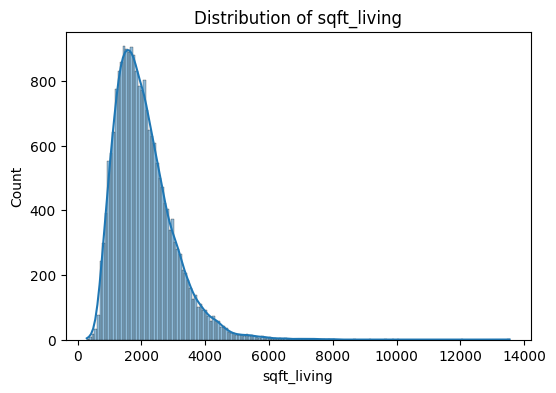

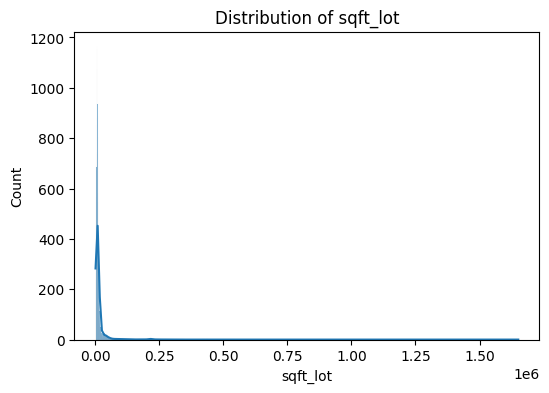

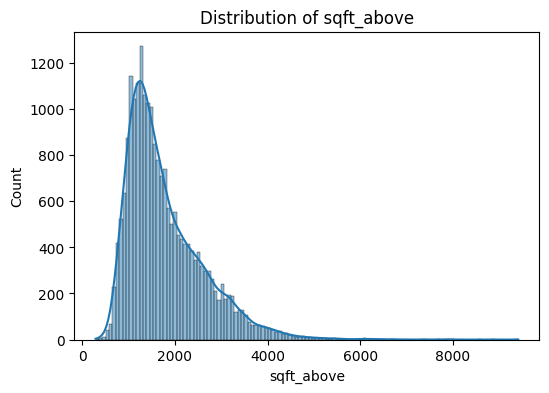

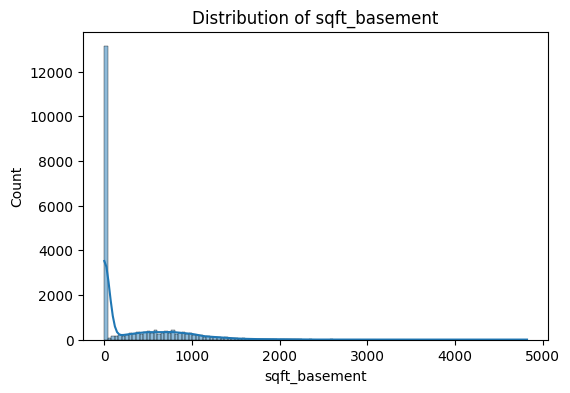

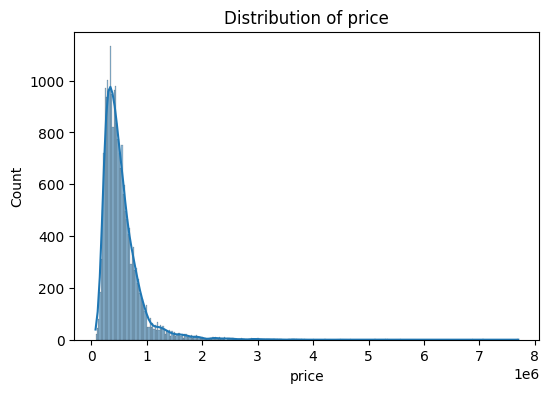

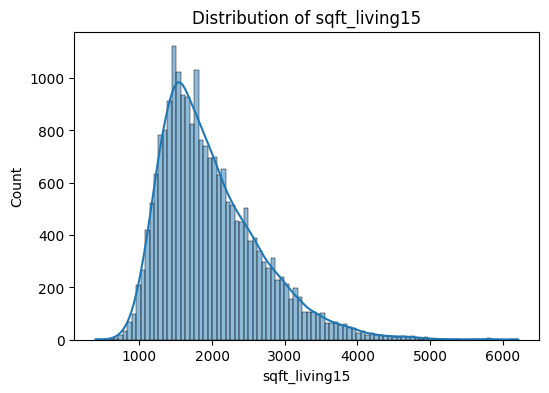

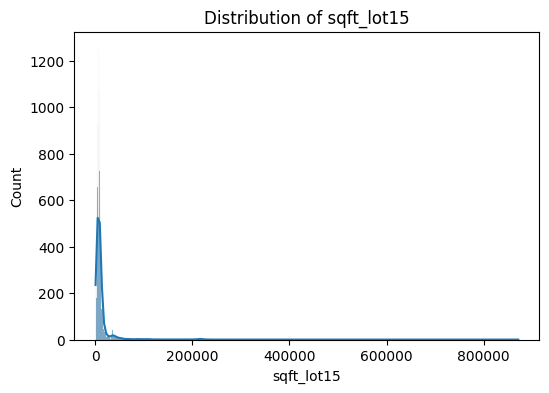

In [177]:
num_cols = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 
            'price', 'sqft_living15', 'sqft_lot15']

for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(data=df, x=col, kde=True)
    plt.title(f'Distribution of {col}')
    plt.show()


#### Feature Distributions

**1. Distribution of `sqft_living`**
- Right-skewed distribution.
- Most homes range between **1,000 and 3,000 sqft**.
- A few outliers reach up to **13,000 sqft**.
- Indicates most homes are moderately sized; larger homes create the long right tail.

**2. Distribution of `sqft_lot`**
- Strongly right-skewed, more extreme than `sqft_living`.
- Most lots are under **20,000 sqft**, but some exceed **1 million sqft**.
- High variation suggests presence of estates, rural, or undeveloped land.

**3. Distribution of `sqft_above`**
- Right-skewed, similar to `sqft_living`.
- Majority fall between **1,000 and 2,500 sqft**.
- Few homes have more than **8,000 sqft** above ground.

**4. Distribution of `sqft_basement`**
- Heavy spike at **0**, indicating many homes without basements.
- Most basements are under **1,000 sqft**.
- Strong right skew with few large basements.

**5. Distribution of `price`**
- Right-skewed distribution typical of housing markets.
- Most homes priced between **$200,000 and $800,000**.
- High-end outliers exceed **$7 million**.

**6. Distribution of `sqft_living15`**
- Roughly **bell-shaped**, slightly right-skewed.
- Majority range from **1,000 to 2,500 sqft**.
- Few homes exceed **4,000–5,000 sqft**.

**7. Distribution of `sqft_lot15`**
- Highly right-skewed.
- Most properties have lot sizes **under 20,000 sqft**.
- Some outliers go beyond **800,000 sqft**, likely atypical land parcels.


### Step 2: Dataset Description
- Dataset: kc_house_data.csv from Kaggle
- Observations: 21,613 houses
- Features: 21 usable features (after dropping Unnamed: 0)
- Target Variable: price

The dataset consists of **21,613 entries** with **22 columns**. Below is a summary of the columns and their types:

- **Unnamed: 0**: Integer column, possibly an index column.
- **id**: Integer column, likely a unique identifier for each listing.
- **date**: Object (string) column, which likely contains the date of the property listing.
- **price**: Float64 column, represents the price of the house (dependent variable).
- **bedrooms**: Float64 column, represents the number of bedrooms in the house (with a few missing values).
- **bathrooms**: Float64 column, represents the number of bathrooms in the house (with a few missing values).
- **sqft_living**: Integer column, represents the square footage of the living area.
- **sqft_lot**: Integer column, represents the square footage of the lot.
- **floors**: Float64 column, represents the number of floors in the house.
- **waterfront**: Integer column, a binary variable (0 or 1), indicating whether the house is located on a waterfront.
- **view**: Integer column, a binary variable indicating if the house has a view.
- **condition**: Integer column, likely represents the condition of the house (scale from 1 to 5).
- **grade**: Integer column, likely represents the quality grade of the house (scale from 1 to 13).
- **sqft_above**: Integer column, represents the square footage of the above-ground living area.
- **sqft_basement**: Integer column, represents the square footage of the basement.
- **yr_built**: Integer column, the year the house was built.
- **yr_renovated**: Integer column, the year the house was renovated.
- **zipcode**: Integer column, the zipcode of the property.
- **lat**: Float64 column, the latitude of the house.
- **long**: Float64 column, the longitude of the house.
- **sqft_living15**: Integer column, square footage of the living area for nearby properties.
- **sqft_lot15**: Integer column, square footage of the lot for nearby properties.

---

#### Missing Values

- **bedrooms**: There are 13 missing values for this column.
- **bathrooms**: There are 10 missing values for this column.

These missing values may require imputation or removal.

### Step 3: Describe dataset's variables
Variable Description Table

| Variable        | Description                  | Type         | Scale     | Role       |
|----------------|------------------------------|--------------|-----------|------------|
| `price`         | Sale price                   | Quantitative | Interval  | Dependent  |
| `bedrooms`      | Number of bedrooms           | Quantitative | Interval  | Independent|
| `bathrooms`     | Number of bathrooms          | Quantitative | Interval  | Independent|
| `sqft_living`   | Living area (in sqft)        | Quantitative | Interval  | Independent|
| `sqft_lot`      | Lot size (in sqft)           | Quantitative | Interval  | Independent|
| `floors`        | Number of floors             | Quantitative | Interval  | Independent|
| `waterfront`    | Waterfront view (0 or 1)     | Categorical  | Nominal   | Independent|
| `view`          | View quality (0–4)           | Ordinal      | Ordinal   | Independent|
| `condition`     | Overall condition (1–5)      | Ordinal      | Ordinal   | Independent|
| `grade`         | Construction quality (1–13)  | Ordinal      | Ordinal   | Independent|
| `sqft_above`    | Living area above ground     | Quantitative | Interval  | Independent|
| `sqft_basement` | Basement area                | Quantitative | Interval  | Independent|
| `yr_built`      | Year built                   | Quantitative | Interval  | Independent|
| `yr_renovated`  | Year renovated               | Quantitative | Interval  | Independent|
| `zipcode`       | Postal code                  | Categorical  | Nominal   | Independent|


### Step 4: All Necessary Libraries Have Been Imported
```python
# Core data manipulation libraries
import pandas as pd                # For loading datasets, handling dataframes, and general data manipulation
import numpy as np                 # For numerical operations, array manipulation, and working with NaNs

# Visualization libraries
import matplotlib.pyplot as plt    # For plotting and visualizing data (line plots, histograms, etc.)
import seaborn as sns              # Built on top of matplotlib, provides high-level plotting for statistical graphics

# Scikit-learn modules for modeling and evaluation
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict  
# Splits dataset into training and test sets; performs cross-validation and prediction for evaluation

from sklearn.pipeline import Pipeline                                  # Allows chaining preprocessing and modeling steps into a pipeline
from sklearn.linear_model import LinearRegression                      # Linear regression algorithm for modeling
from sklearn.metrics import mean_squared_error, r2_score               # Metrics for evaluating regression model performance

# Feature-engine modules for preprocessing
from feature_engine.imputation import MeanMedianImputer                # Imputes missing values using mean or median
from feature_engine.encoding import OneHotEncoder                      # Encodes categorical variables using one-hot encoding
from feature_engine.outliers import Winsorizer                         # Handles outliers using winsorization (capping values)
from feature_engine.discretisation import EqualWidthDiscretiser        # Bins continuous variables into equal-width intervals
from feature_engine.transformation import LogTransformer               # Applies log transformation to reduce skewness in numerical variables


### Step 5: Feature Engineering using Feature-engine

In [178]:
# Missing Data Imputation
imputer = MeanMedianImputer(imputation_method='median', variables=['bedrooms', 'bathrooms'])

#### Missing Data Imputation

We use `MeanMedianImputer` with the **median** strategy to handle missing values in `bedrooms` and `bathrooms`. Median imputation is preferred here because it is **robust to outliers** and better represents the central tendency for skewed distributions, ensuring more reliable estimates than the mean.


In [179]:
# Define the encoder
encoder = OneHotEncoder(variables=['waterfront', 'view'], drop_last=True)


#### One-Hot Encoding

We apply `OneHotEncoder` to the categorical variables `waterfront` and `view` to convert them into numerical format for modeling. The `drop_last=True` option helps prevent multicollinearity by dropping the last category in each feature, which is useful for linear models.


In [180]:
# Outlier Handling
outlier_handler = Winsorizer(capping_method='iqr',
                              tail='right',
                              fold=1.5,
                              variables=['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement'])


#### Outlier Handling

We use `Winsorizer` with the **IQR method** to cap extreme values on the **right tail** (upper outliers) of selected features. This approach helps reduce the impact of unusually large values in variables like `sqft_living`, `sqft_lot`, `sqft_above`, and `sqft_basement`, which are often right-skewed in housing data.


In [181]:
# Discretization
discretiser = EqualWidthDiscretiser(bins=5, variables=['yr_built'])

#### Discretization

We apply `EqualWidthDiscretiser` to divide the `yr_built` feature into **5 equal-width bins**. This simplifies the continuous year variable into grouped intervals, helping capture patterns or trends based on when houses were built.


In [182]:
# Variable Transformation
cols_to_log = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']
df[cols_to_log] = df[cols_to_log] + 1e-6  # Add a small constant to avoid log(0)
log_transformer = LogTransformer(variables=cols_to_log)

#### Variable Transformation (Log Transformation)

We apply a `LogTransformer` to variables like `sqft_living`, `sqft_lot`, `sqft_above`, and `sqft_basement`, after adding a small constant (`1e-6`) to avoid issues with zero values.  
Log transformation helps **reduce right skewness**, **stabilize variance**, and **make patterns more linear**, which can improve the performance of regression models.


### Step 6: Split dataset into training and testing sets

In [183]:
X = df.drop('price', axis=1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Step 7-8: Import the pipeline class and create a pipeline object

In [184]:
pipeline = Pipeline(steps=[
    ('imputer', imputer),
    ('outliers', outlier_handler),
    ('discretiser', discretiser),
    ('transformer', log_transformer),
    ('encoder', encoder),
    ('regressor', LinearRegression())
])


#### Building the Regression Pipeline

We create a `Pipeline` to streamline preprocessing and modeling steps into a single, reusable workflow.  
The steps include:  
1. **Imputation** for missing values  
2. **Outlier handling**  
3. **Discretization** of year built  
4. **Log transformation** of skewed variables  
5. **One-hot encoding** of categorical features  
6. **Linear regression** as the final estimator  

This setup ensures that all transformations are consistently applied during both training and prediction.


### Step 9: Fit the pipeline to the training data

In [185]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('imputer',
                 MeanMedianImputer(variables=['bedrooms', 'bathrooms'])),
                ('outliers',
                 Winsorizer(capping_method='iqr', fold=1.5,
                            variables=['sqft_living', 'sqft_lot', 'sqft_above',
                                       'sqft_basement'])),
                ('discretiser',
                 EqualWidthDiscretiser(bins=5, variables=['yr_built'])),
                ('transformer',
                 LogTransformer(variables=['sqft_living', 'sqft_lot',
                                           'sqft_above', 'sqft_basement'])),
                ('encoder',
                 OneHotEncoder(drop_last=True,
                               variables=['waterfront', 'view'])),
                ('regressor', LinearRegression())])

#### Fitting the Pipeline

We fit the entire pipeline on the training data using `pipeline.fit(X_train, y_train)`.  
This applies all preprocessing steps in sequence and trains the **Linear Regression** model on the cleaned and transformed features.


### Step 10: Make predictions and Evaluate the model

In [186]:
# Make predictions and evaluate the model
y_pred = pipeline.predict(X_test)

# Calculate RMSE and R2 score
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

# Step 13: Report RMSE and R2 values
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'R-Squared (R2): {r2*100:.2f}%')

Root Mean Squared Error (RMSE): 241909.43
R-Squared (R2): 61.29%


#### Making Predictions and Evaluating the Model

We use the trained pipeline to make predictions on the test set with `pipeline.predict(X_test)`.  
The model performance is evaluated using two metrics:  
- **RMSE (Root Mean Squared Error)**: Measures the average magnitude of the errors in the predictions. A lower value indicates better accuracy.
- **R² (R-Squared)**: Represents the proportion of variance in the target variable that is explained by the model. Higher values (closer to 1) indicate a better fit.

**Results:**
- **RMSE**: 241,909.43  
- **R²**: 61.29%  
These values show that the model explains about 61.29% of the variance in house prices, with some room for improvement.


In [187]:
# R-sqaure
r2 = cross_val_score(pipeline, X_train, y_train, scoring='r2', cv=5).mean()

# RMSE
preds = cross_val_predict(pipeline, X_train, y_train, cv=5)
rmse = np.sqrt(mean_squared_error(y_train, preds))

print(f"Cross-Validated R2: {r2*100:.2f}%")
print(f"Cross-Validated RMSE: {rmse:.2f}")


Cross-Validated R2: 62.21%
Cross-Validated RMSE: 222726.41


#### Cross-Validation for Model Evaluation

To better assess the model's performance, we use **cross-validation**:  
- **R² (R-Squared)** is calculated using `cross_val_score` with 5-fold cross-validation. It measures how well the model explains the variance in the target variable.
- **RMSE (Root Mean Squared Error)** is calculated using `cross_val_predict`, which predicts outcomes for each fold and computes the error.

**Results:**
- **Cross-Validated R²**: 62.21%  
- **Cross-Validated RMSE**: 222,726.41  

These results indicate that the model generalizes reasonably well, with an improvement in RMSE compared to the initial holdout test set.


link to the dataset: https://www.kaggle.com/code/shiv28/house-price-prediction-in-king-county-usa?select=kc_house_data_NaN.csv